# NLP: Analyzing Healthcare Reviews

## Introduction

It is difficult to find a good doctor who will always take the patient’s best interest as top priority. Although patients are no experts, they do have the first-hand experience of the treatment and know exactly how they feel before and after treatment. One way to judge the quality of a doctor’s diagnosis or treatment is to go directly to listen to what the patients would say. Yelp’s business dataset contains 10,211 different healthcare organizations in 11 cities across 4 countries and 114,556 reviews about them.  

I propose to analyze Yelp reviews on hospitals, doctors, dentists and other health professionals to better understand what makes a healthcare practice excellent from the patients’ perspective. I will use latent Dirichlet allocation (LDA) to discover prominent topics among these one hundred thousand reviews on patients’ experiences. Such topic modelling will help us see the common themes that patients tend to compliment or complain about. I can use pyLDAvis library to visualize the topic model with an interactive interface to help explore the topics discovered. 

I will also train a word vector model with word2vec using gensim library. I can visualize the word vectors by reducing dimensionality with t-Distributed Stochastic Neighbor Embedding. This word2vec model can be used to produce automatic summary of all the reviews of a healthcare practice or to predict the positive or negative sentiment toward a practice in a review. 

In sum, the automatic summary of key points for each healthcare practice will make it easier for patients to find a good-quality doctor who genuinely cares for the patients. Insights on what patients tend to compliment or complain about will help healthcare practices improve their service by gaining a more thorough understanding what it is like to be at the receiving end of various treatments. 



## Overview

1. Use [**spaCy**](https://spacy.io) to process text: Tokenization, text normalization, sentence detection 
1. Apply phrase modeling: Look for words that appear one after another as multi-word concepts
1. Discover topics with LDA: Find topics for each review based on the words used
1. Visualize the topic model with [**pyLDAvis**](https://pyldavis.readthedocs.io/en/latest/readme.html) library
1. Describe text with LDA: Each review might look like Topic A and Topic B with some probabilities
1. Train a word vector model with word2vec using [**gensim**](https://radimrehurek.com/gensim/index.html) library: Predict which word will appear in a given context
1. Visuailize word vectors by reducing dimensionality with t-Distributed Stochastic Neighbor Embedding or [TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [1]:
import os
import codecs

data_directory = os.path.join('C:/Users/andre/Documents/', 'yelp_dataset_challenge_round9')

businesses_filepath = os.path.join(data_directory, 'yelp_academic_dataset_business.json')

with codecs.open(businesses_filepath, encoding='utf_8') as f:
    first_business_record = f.readline() 

print (first_business_record)

{"business_id":"0DI8Dt2PJp07XkVvIElIcQ","name":"Innovative Vapors","neighborhood":"","address":"227 E Baseline Rd, Ste J2","city":"Tempe","state":"AZ","postal_code":"85283","latitude":33.3782141,"longitude":-111.936102,"stars":4.5,"review_count":17,"is_open":0,"attributes":["BikeParking: True","BusinessAcceptsBitcoin: False","BusinessAcceptsCreditCards: True","BusinessParking: {'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}","DogsAllowed: False","RestaurantsPriceRange2: 2","WheelchairAccessible: True"],"categories":["Tobacco Shops","Nightlife","Vape Shops","Shopping"],"hours":["Monday 11:0-21:0","Tuesday 11:0-21:0","Wednesday 11:0-21:0","Thursday 11:0-21:0","Friday 11:0-22:0","Saturday 10:0-22:0","Sunday 11:0-18:0"],"type":"business"}



In [2]:
review_json_filepath = os.path.join(data_directory, 'yelp_academic_dataset_review.json')

with codecs.open(review_json_filepath, encoding='utf_8') as f:
    first_review_record = f.readline()
    
print (first_review_record)

{"review_id":"NxL8SIC5yqOdnlXCg18IBg","user_id":"KpkOkG6RIf4Ra25Lhhxf1A","business_id":"2aFiy99vNLklCx3T_tGS9A","stars":5,"date":"2011-10-10","text":"If you enjoy service by someone who is as competent as he is personable, I would recommend Corey Kaplan highly. The time he has spent here has been very productive and working with him educational and enjoyable. I hope not to need him again (though this is highly unlikely) but knowing he is there if I do is very nice. By the way, I'm not from El Centro, CA. but Scottsdale, AZ.","useful":0,"funny":0,"cool":0,"type":"review"}



In [3]:
import json
import numpy as np

healthcare_ids = []

# open the businesses file
with codecs.open(businesses_filepath, encoding='utf_8') as f:
    
    # iterate through each line (json record) in the file
    for business_json in f:
        
        # convert the json record to a Python dict
        business = json.loads(business_json)
        
        # if this business has no categories or is not a target entity, skip to the next one
        if business[u'categories'] is None or u'Health & Medical' not in business[u'categories']:
            continue
        # Remove businesses in BW, Germany
        if u'BW' in business[u'state']:
            continue
        # Remove businesses that are restaurants, food and pets
        if u'Restaurants' in business[u'categories'] or u'Food' in business[u'categories'] or 'Pets' in business[u'categories']:
            continue
            
        # add the business id to our healthcare_ids set
        healthcare_ids.append(business[u'business_id'])

# Turn the list of ids into a set, which is faster for testing whether an element is in the set
healthcare_ids = set(healthcare_ids)

# print the number of unique ids in the dataset
print ('{:,}'.format(len(healthcare_ids)), u'health & medical entities in the dataset.')

10,211 health & medical entities in the dataset.


In [4]:
intermediate_directory = os.path.join(data_directory, 'intermediate')

review_txt_filepath = os.path.join(intermediate_directory,
                                   'review_text_all.txt')

In [5]:
# Create a new file that contains only the text from reviews about healthcare entities.
# One review per line in the this new file.
    
review_count = 0
useful = []
stars = []

# create & open a new file in write mode
with codecs.open(review_txt_filepath, 'w', encoding='utf_8') as review_txt_file:

    # open the existing review json file
    with codecs.open(review_json_filepath, encoding='utf_8') as review_json_file:

        # loop through all reviews in the existing file and convert to dict
        for review_json in review_json_file:
            review = json.loads(review_json)

            # if this review is not in the target set, skip to the next one
            if review[u'business_id'] not in healthcare_ids:
                continue

            # write each review as a line in the new file
            # escape newline characters in the original review text
            if review[u'text'] is None:
                print(review_count)
            
            review_txt_file.write(review[u'text'].replace('\n', '\\n').replace('\r','') + '\n')
            review_count += 1
            useful.append(review[u'useful'])
            stars.append(review[u'stars'])

print (u'Text from {:,} healthcare reviews written to the new txt file.'.format(review_count))

Text from 114,556 healthcare reviews written to the new txt file.


In [6]:
useful = np.array(useful)
stars = np.array(stars)
luseful = np.log(useful+1)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

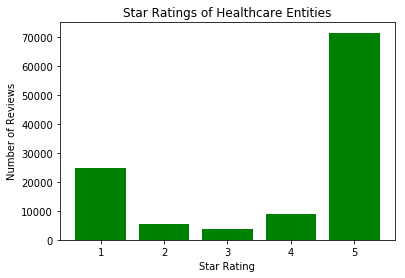

In [8]:
hist, bins = np.histogram(stars, bins=5)
plt.bar(range(1, 6), hist, color='green', width=0.8, align='center')
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.title('Star Ratings of Healthcare Entities')
plt.show()

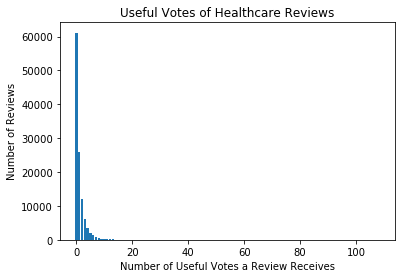

In [9]:
unique, counts = np.unique(useful, return_counts = True)
plt.bar(unique,counts)
plt.xlabel('Number of Useful Votes a Review Receives')
plt.ylabel('Number of Reviews')
plt.title('Useful Votes of Healthcare Reviews')
plt.show()

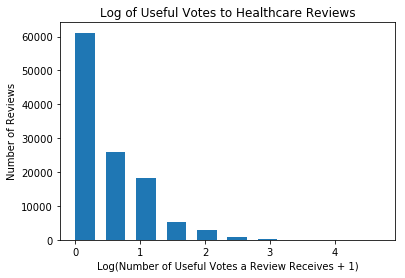

In [10]:
plt.hist(luseful, bins = 10, width = 0.3, align='mid')
plt.xlabel('Log(Number of Useful Votes a Review Receives + 1)')
plt.ylabel('Number of Reviews')
plt.title('Log of Useful Votes to Healthcare Reviews')
plt.show()

### Preprocessing the Text

Use spaCy to tokenize, lemmitize and remove stopwords from the text. Apply phrase modeling by looking for words that tend to appear one after another more frequently than by random chance.

In [11]:
import spacy
import pandas as pd
import itertools as it

nlp = spacy.load('en')

In [12]:
with codecs.open(review_txt_filepath, encoding='utf_8') as f:
    sample_review = list(it.islice(f, 9005, 10000))[0]
    sample_review = sample_review.replace('\\n', '\n')
        
print (sample_review)

Great dentist for kids...been going here for years. The practice is well run and managed and the dentist is super careful with the kids...they never feel any pain.



In [13]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence

In [14]:
def punct_space(token):
    """Eliminate tokens that are pure punctuation or white space"""
    
    return token.is_punct or token.is_space

def person(token):
    """Remove tokens that are PERSON entities"""
    
    return token.ent_type_ == 'PERSON'

def line_review(filename):
    """Generator function (iterator without storing all texts)
    to read in reviews from file and return the original line breaks"""
    
    with codecs.open(filename, encoding='utf_8') as f:
        for review in f:
            yield review.replace('\\n', '\n')

def lemmatized_sentence_corpus(filename):
    """Generator function to use spaCy to parse reviews, lemmatize the text and yield sentences"""
    
    for parsed_review in nlp.pipe(line_review(filename), batch_size=10000, n_threads=4):
        for sent in parsed_review.sents:
            yield u' '.join([token.lemma_ for token in sent if not (punct_space(token) or person(token))])

In [15]:
unigram_sentences_filepath = os.path.join(intermediate_directory, 'unigram_sentences_all.txt')

In [16]:
# Segment reviews into sentences and normalize the text
# Save the parsed sentences file on disk to avoid storing the entire corpus in RAM
if 1 == 1:
    with codecs.open(unigram_sentences_filepath, 'w', encoding='utf_8') as f:
        for sentence in lemmatized_sentence_corpus(review_txt_filepath):
            f.write(sentence + '\n')

In [17]:
# gensim's LineSentence class takes the format: one sentence = one line
# words are preprocessed and separated by whitespace.
unigram_sentences = LineSentence(unigram_sentences_filepath)

In [18]:
for unigram_sentence in it.islice(unigram_sentences, 0, 3):
    print (unigram_sentence)

['lovely', 'yoga', 'studio', 'close', 'to']
['when', '-PRON-', 'move', 'to', 'charlotte', '-PRON-', 'be', 'look', 'for', 'a', 'new', 'yoga', 'studio', 'to', 'try', 'and', 'hear', 'about', 'this', 'place']
['-PRON-', 'really', 'be', 'not', 'like', 'any', 'yoga', 'studio', '-PRON-', 'be', 'use', 'to', 'go', 'to']


In [19]:
bigram_model_filepath = os.path.join(intermediate_directory, 'bigram_model_all')

In [20]:
# Run a phrase model to link two-words phrases together
if 1 == 1:
    bigram_model = Phrases(unigram_sentences)
    bigram_model.save(bigram_model_filepath)

else:
    bigram_model = Phrases.load(bigram_model_filepath)

In [21]:
bigram_sentences_filepath = os.path.join(intermediate_directory, 'bigram_sentences_all.txt')

In [22]:
# Apply the bigram model to unigram sentences and create a text with bigram sentences
if 1 == 1:
    with codecs.open(bigram_sentences_filepath, 'w', encoding='utf-8') as f:
        for unigram_sentence in unigram_sentences:
            bigram_sentence = u' '.join(bigram_model[unigram_sentence])
            f.write(bigram_sentence + '\n')

In [23]:
bigram_sentences = LineSentence(bigram_sentences_filepath)

In [24]:
for bigram_sentence in it.islice(bigram_sentences, 10, 15):
    print(bigram_sentence)

['-PRON-', 'never', 'once', 'feel', 'out', 'of', 'place', 'or', 'that', '-PRON-', 'be', 'a', 'competition', 'something', '-PRON-', 'have', 'often', 'feel', 'at', 'other', 'studio', 'especially', 'here', 'in', 'charlotte']
['there', 'be', 'shower', 'locker', 'cubby', 'and', 'even', 'a', 'meditation', 'room']
['really', 'enjoyable', 'overall', 'and', 'somewhere', '-PRON-', 'would', 'recommend', 'to', 'other']
['-PRON-', 'crossfit', 'and', 'sometimes', '-PRON-', 'get', 'sore_muscle']
['-PRON-', 'decide', 'to', 'attend', 'a', 'hot_yoga', 'class', 'to', 'stretch', 'out', '-PRON-', 'sore_muscle']


In [25]:
trigram_model_filepath = os.path.join(intermediate_directory, 'trigram_model_all')

In [26]:
if 1 == 1:
    trigram_model = Phrases(bigram_sentences)
    trigram_model.save(trigram_model_filepath)
else:
    trigram_model = Phrases.load(trigram_model_filepath)

In [27]:
trigram_sentences_filepath = os.path.join(intermediate_directory, 'trigram_sentences_all.txt')

In [28]:
if 1 == 1:
    with codecs.open(trigram_sentences_filepath, 'w', encoding='utf_8') as f:
        for bigram_sentence in bigram_sentences:
            trigram_sentence = u' '.join(trigram_model[bigram_sentence])
            f.write(trigram_sentence + '\n')            

In [29]:
trigram_sentences = LineSentence(trigram_sentences_filepath)

In [30]:
for trigram_sentence in it.islice(trigram_sentences, 2710, 2713):
    print(trigram_sentence)    

['doc', 'walk', 'in', 'and', '-PRON-', 'realize', '-PRON-', 'work', 'on', '-PRON-', 'awhile', 'back', 'when', '-PRON-', 'be', 'both', 'ad']
['-PRON-', 'be', 'a', 'major', 'then']
['small', 'world']


In [31]:
trigram_reviews_filepath = os.path.join(intermediate_directory, 'trigram_transformed_reviews_all.txt')

In [32]:
# Write a transformed text into a new file, with one review per line
if 1 == 1:
    with codecs.open(trigram_reviews_filepath, 'w', encoding='utf-8') as f:
        for parsed_review in nlp.pipe(line_review(review_txt_filepath), batch_size=10000, n_threads=4):
            
            # Lemmatize the text, removing punctuation and whitespace
            unigram_review = [token.lemma_ for token in parsed_review 
                              if not (punct_space(token) or person(token))]
            
            # Apply the first-order and second-order phrase models
            bigram_review = bigram_model[unigram_review]
            trigram_review = trigram_model[bigram_review]
            
            # Remove any remaining stopwords
            trigram_review = [term for term in trigram_review 
                              if term not in spacy.en.language_data.STOP_WORDS]
            
            # Write the transformed review as a new line
            trigram_review = u' '.join(trigram_review)
            f.write(trigram_review + '\n')

In [33]:
print (u'Original:' + u'\n')
for review in it.islice(line_review(review_txt_filepath), 56044, 56047):
    print(review)
print(u'Transformed:' + u'\n')
with codecs.open(trigram_reviews_filepath, encoding='utf-8') as f:
    for review in it.islice(f, 56044, 56047):
        print(review)

Original:

I went to Labcorp to have my blood drawn.  It's hard to say something nice about people who poke me with needles... but their staff was lighthearted and kind to a poor girl who's squeamish about giving blood.

-1 star because their lobby is small and their lovely flat-screen tv only loops mind-numbing healthcare "infomercials".

This facility has moved across the street to 3815 E. Bell suite 1405.  This clinic is behind the 3811 building so its kind of hard to see and tricky to get to.

The waiting area is much bigger than the other labcorp facilities to accommodate the average wait time of 40 mins for any walk in, so make sure you get an appointment thru their intuitive reservation system online @ www.labcorp.com 

As much as I hate needles the Phlebotomist I had was a uber pro leet, got poked without even knowing, not sure if that a good or a bad thing.  Anyways it was much better than the one I had from Sonora Quest who left a bruise my arm and scar that lasted 2 weeks. B

In [53]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LsiModel
from gensim.matutils import cossim

import pyLDAvis, pyLDAvis.gensim
import warnings
import pickle

In [38]:
trigram_dictionary_filepath = os.path.join(intermediate_directory, 'trigram_dict_all.dict')

In [39]:
trigram_reviews = LineSentence(trigram_reviews_filepath)

In [40]:
# Learn the full vocabulary of the corpus, using gensim's Dictionary class
trigram_dictionary = Dictionary(trigram_reviews)
print(trigram_dictionary)

Dictionary(79693 unique tokens: ['lovely', 'yoga_studio', 'close', '-PRON-', 'charlotte']...)


In [41]:
# Filter out words that appear in less than 200 reivews or more than 30% of reviews
trigram_dictionary.filter_extremes(no_below=200, no_above=0.3)

# Filter out other unuseful words used in reviews
#stoplist = set('feel tell come like'.split())
#stop_ids = [trigram_dictionary.token2id[stopword] for stopword in stoplist]
#trigram_dictionary.filter_tokens(stop_ids)

print(trigram_dictionary)

Dictionary(2285 unique tokens: ['lovely', 'close', 'charlotte', 'look', 'new']...)


In [82]:
# Reassign integer ids
trigram_dictionary.compactify()
trigram_dictionary.save(trigram_dictionary_filepath)
trigram_dictionary = Dictionary.load(trigram_dictionary_filepath)

In [45]:
trigram_bow_filepath = os.path.join(intermediate_directory, 'trigram_bow_corpus_all.mm')

In [46]:
def trigram_bow_generator(filepath):
    """Generator function to read reviews from a file and yield a bag-of-words representation"""
    for review in LineSentence(filepath):
        yield trigram_dictionary.doc2bow(review)

In [47]:
# Build a bag-of-words corpus
# Generate bag-of-words representations for all reviews and save them in matrix market format

MmCorpus.serialize(trigram_bow_filepath, trigram_bow_generator(trigram_reviews_filepath))
trigram_bow_corpus = MmCorpus(trigram_bow_filepath)

In [48]:
lda_model_filepath = os.path.join(intermediate_directory, 'lda_model_all')

In [84]:
# To build the topic model, pass the bag-of-words matrix and Dictionary to LdaMulticore as inputs
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    # workers = # of cores minus one
    lda = LdaMulticore(trigram_bow_corpus, num_topics=30, id2word=trigram_dictionary, 
                       workers=3, iterations=300, passes=5, random_state=0)

lda.save(lda_model_filepath)
lda = LdaMulticore.load(lda_model_filepath)

### Topic Modeling

Among the 30 topics, there are about 5 clearly positive topics. One is extremely emotional, using words such as awesome, super, sweet and love. Another is more descriptive with words like friendly, clean, professional and knowledgeable. The third topic uses words such as care, truly and compassionate. The fourth is about the 'amazing' results from cosmetic surgeries or treatments, and the fifth is about a somewhat 'comfortable' experience at the dentist. 

On the opposite side, there are 4 topics that are likely to be negative. One uses word like rude, bad, and attitude. Another topic talks about wait, hour and waiting room. The third topic mentions manager, error, cancel and refund, and the last topic focuses on insurance, bill, and payment.

The model identifies some other clear topics such as pediatrics, optometrist, surgery, chiropractor, primary care physician, pregnancy and delivery, hospital and emergency room, prescription and drugs, and a more neutral topic on the dentists focusing on actual works of crown, root canal and cavity. There is also a topic for fitness and yoga instructors and another for massage therapists. Some people also comment on topics such as making appointments, referring to other Yelp reviews, inquiring for lab results or medical records, and talking about the price, discount and coupons.




In [70]:
def explore_topic(topic_number, topn=10):
    """Print out a list of top terms for a specified topic number"""
    print (u'{:20} {}'.format(u'Topic ' + str(topic_number), u'Frequency') + u'\n')
    for term, frequency in lda.show_topic(topic_number, topn):
        print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    print (u' ')

In [87]:
explore_topic(0)

Topic 0              Frequency

friendly             0.079
great                0.046
professional         0.043
place                0.042
clean                0.039
service              0.027
nice                 0.023
helpful              0.019
highly_recommend     0.018
experience           0.018
 


In [72]:
LDAvis_data_filepath = os.path.join(intermediate_directory, 'ldavis_prepared')

In [85]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda, trigram_bow_corpus, trigram_dictionary)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

In [86]:
pyLDAvis.display(LDAvis_prepared)

In [ ]:
pyLDAvis.save_html(LDAvis_prepared, 'LDAvis30a.html')

In [42]:
trigram_dictionary = Dictionary(trigram_reviews)
# Filter out words that appear in less than 100 reivews or more than 30% of reviews
trigram_dictionary.filter_extremes(no_below=250, no_above=0.3)
trigram_dictionary.compactify()
print(trigram_dictionary)

Dictionary(1992 unique tokens: ['lovely', 'close', 'charlotte', 'look', 'new']...)


In [49]:
# To build the topic model, pass the bag-of-words matrix and Dictionary to LdaMulticore as inputs
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    # workers = # of cores minus one
    lda = LdaMulticore(trigram_bow_corpus, num_topics=30, id2word=trigram_dictionary, 
                       workers=3, iterations=300, passes=5, random_state=0)

LDAvis_prepared = pyLDAvis.gensim.prepare(lda, trigram_bow_corpus, trigram_dictionary)

In [50]:
pyLDAvis.display(LDAvis_prepared)

In [51]:
lda.print_topics(-1, 3)

[(0, '0.097*"place" + 0.095*"great" + 0.050*"love"'),
 (1, '0.084*"care" + 0.070*"dr." + 0.040*"patient"'),
 (2, '0.060*"office" + 0.043*"dr." + 0.043*"dentist"'),
 (3, '0.110*"dentist" + 0.061*"dental" + 0.051*"tooth"'),
 (4, '0.077*"glass" + 0.041*"frame" + 0.029*"pair"'),
 (5, '0.044*"tooth" + 0.032*"tell" + 0.031*"x_ray"'),
 (6, '0.129*"eye" + 0.057*"contact" + 0.042*"exam"'),
 (7, '0.129*"massage" + 0.022*"feel" + 0.020*"place"'),
 (8, '0.118*"kid" + 0.114*"son" + 0.100*"daughter"'),
 (9, '0.047*"hospital" + 0.046*"nurse" + 0.025*"er"'),
 (10, '0.101*"pain" + 0.032*"feel" + 0.023*"help"'),
 (11, '0.063*"treatment" + 0.021*"feel" + 0.020*"offer"'),
 (12, '0.066*"baby" + 0.024*"deliver" + 0.023*"husband"'),
 (13, '0.082*"dr." + 0.041*"feel" + 0.040*"question"'),
 (14, '0.049*"review" + 0.039*"look" + 0.019*"want"'),
 (15, '0.088*"surgery" + 0.027*"day" + 0.021*"dr."'),
 (16, '0.078*"skin" + 0.059*"product" + 0.037*"facial"'),
 (17, '0.116*"wait" + 0.050*"hour" + 0.025*"come"'),
 (18

Latent Semantic Indexing (LSI)


In [58]:
lsi = LsiModel(trigram_bow_corpus, num_topics=30, id2word=trigram_dictionary)

In [60]:
lsi.print_topics(-1, 3)

[(0, '0.250*"dr." + 0.248*"office" + 0.238*"tell"'),
 (1, '0.664*"dr." + -0.275*"tell" + 0.263*"office"'),
 (2, '-0.473*"doctor" + 0.390*"massage" + -0.287*"office"'),
 (3, '-0.468*"dentist" + 0.405*"doctor" + -0.296*"office"'),
 (4, '0.471*"office" + -0.413*"tell" + 0.359*"appointment"'),
 (5, '-0.535*"appointment" + -0.443*"dr." + 0.356*"doctor"'),
 (6, '-0.493*"office" + -0.403*"massage" + 0.388*"appointment"'),
 (7, '-0.547*"doctor" + -0.422*"massage" + -0.367*"dentist"'),
 (8, '-0.519*"wait" + 0.376*"appointment" + -0.259*"come"'),
 (9, '0.543*"feel" + 0.399*"like" + -0.392*"great"'),
 (10, '0.438*"care" + -0.337*"place" + -0.328*"like"'),
 (11, '0.536*"great" + -0.431*"place" + -0.281*"patient"'),
 (12, '-0.627*"work" + 0.362*"care" + 0.261*"tell"'),
 (13, '-0.567*"place" + 0.241*"wait" + 0.222*"glass"'),
 (14, '-0.450*"work" + -0.373*"tell" + 0.360*"come"'),
 (15, '-0.593*"come" + 0.288*"wait" + 0.276*"day"'),
 (16, '-0.417*"come" + -0.344*"feel" + 0.329*"day"'),
 (17, '-0.370*"

## Evaluation


In [61]:
def intra_inter(model, num_pairs=10000):
    # Split each review into two halves and compute topics for each half
    part1 = [model[trigram_dictionary.doc2bow(review[: len(review)/2])] for review in trigram_reviews]
    part2 = [model[trigram_dictionary.doc2bow(review[len(review)/2 :])] for review in trigram_reviews]
    
    # Print computed consine similarities
    print("Average cosine similarity between corresponding parts:")
    print(np.mean([cossim(p1, p2) for p1, p2 in zip(part1, part2)]))
    
    random_pairs = np.random.randint(len(trigram_reviews), size=(num_pairs, 2))
    print("Average cosine similarity between randomly mixed pairs:")
    print(np.mean([cossim(part1[i[0]], part2[i[1]]) for i in random_pairs]))

In [62]:
intra_inter(lda)

TypeError: slice indices must be integers or None or have an __index__ method